In [2]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Dropout, Lambda, LSTM, GRU, Bidirectional, Layer, Attention, Conv1D, Flatten, GlobalMaxPooling1D
from keras_self_attention import SeqSelfAttention
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Customers_in_a_Shop.csv', header=None)
df.head()

,0,1
0,1949-01,114.0
1,1949-02,120.0
2,1949-03,134.0
3,1949-04,67.0
4,1949-05,123.0


In [4]:
df.columns={"Date","Customers"}
print(df.isnull().sum())

Date         0
Customers    4
dtype: int64


In [5]:
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m")
df = df.set_index('Date')
df

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,720.0


In [6]:
missing = df[df.isna().any(axis=1)]
print(missing)

            Customers
Date                 
1951-06-01        NaN
1951-07-01        NaN
1954-06-01        NaN
1960-03-01        NaN


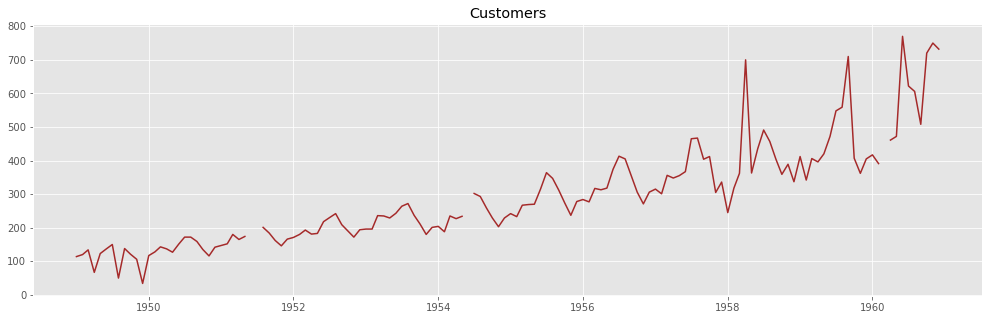

In [7]:
#from matplotlib import style
#print(plt.style.available)

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(17,5)

plt.plot(df, color='brown')
plt.title("Customers")
plt.show()

## Imputing missing values

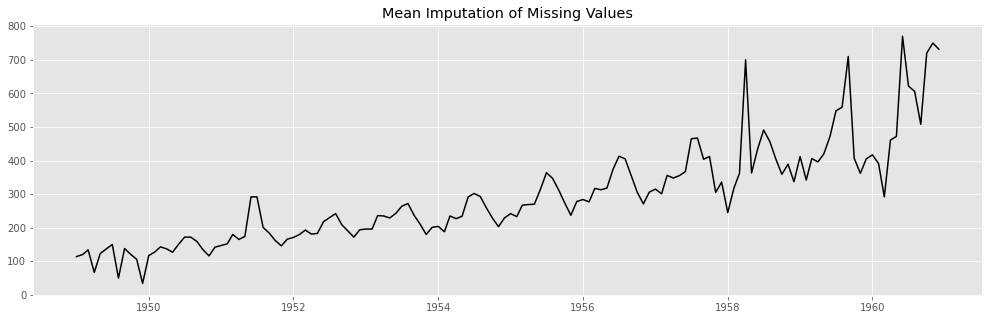

In [8]:
## Comparing several types of interpolations - mean 
plt.rcParams['figure.figsize']=(17,5)
df['Customers_mean'] = df['Customers'].fillna(df['Customers'].mean())
plt.plot(df['Customers_mean'],color='black')
plt.title("Mean Imputation of Missing Values")
plt.show()

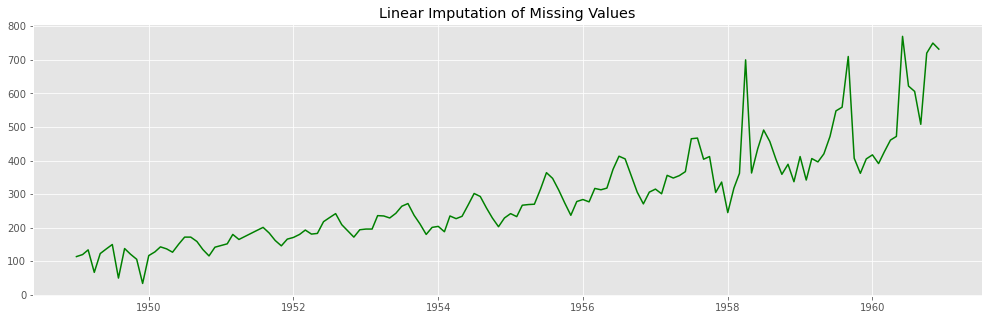

In [9]:
## Comparing several types of interpolations - linear
plt.rcParams['figure.figsize']=(17,5)
df['Customers_linear'] = df['Customers'].interpolate(method='linear')
plt.plot(df['Customers_linear'],color='green')
plt.title("Linear Imputation of Missing Values")
plt.show()

In [10]:
df1 = df['1949-06':'1960-06':12]
df1

,Customers,Customers_mean,Customers_linear
Date,,,
1949-06-01,137.0,137.000000,137.0
1950-06-01,151.0,151.000000,151.0
1951-06-01,NaN,291.878571,183.0
1952-06-01,218.0,218.000000,218.0
1953-06-01,243.0,243.000000,243.0
1954-06-01,NaN,291.878571,268.0
1955-06-01,315.0,315.000000,315.0
1956-06-01,374.0,374.000000,374.0
1957-06-01,367.0,367.000000,367.0


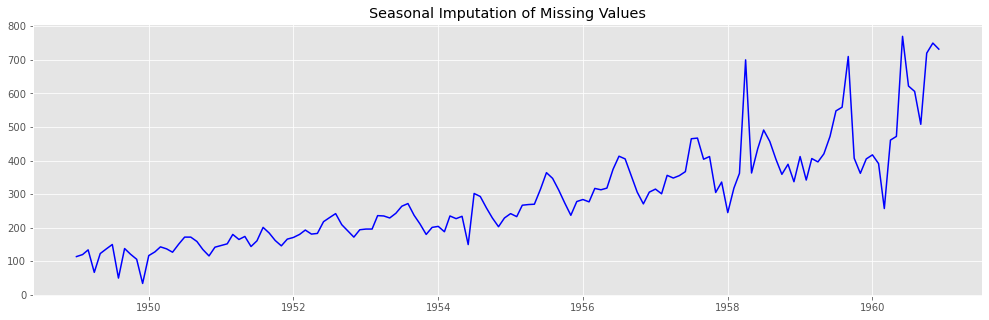

In [11]:
## Comparing several types of interpolations - seasonal interpolation
df.loc['1960-03'].fillna((df['1949-03':'1959-03':12].sum())/df['1949-03':'1959-03':12].shape[0], inplace=True)
df.loc['1954-06'].fillna((df['1949-06':'1953-06':12].sum())/(df['1949-06':'1953-06':12].shape[0]), inplace=True)
df.loc['1951-07'].fillna((df['1949-07':'1950-07':12].sum())/(df.loc['1949-07':'1950-07':12].shape[0]), inplace=True)
df.loc['1951-06'].fillna((df['1949-06':'1950-06':12].sum())/(df['1949-06':'1950-06':12].shape[0]), inplace=True)

plt.rcParams['figure.figsize']=(17,5)
plt.plot(df['Customers'],color='blue')
plt.title("Seasonal Imputation of Missing Values")
plt.show()

In [12]:
df['Customers'].sort_values(ascending=False).head(7)

Date
1960-06-01    770.0
1960-11-01    750.0
1960-12-01    732.0
1960-10-01    720.0
1959-09-01    710.0
1958-04-01    700.0
1960-07-01    622.0
Name: Customers, dtype: float64

## Normality plots 

/home/ardavan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Customers', ylabel='Density'>

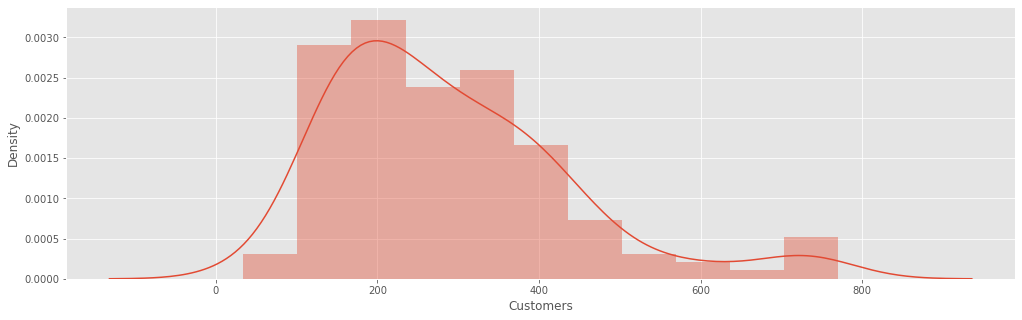

In [13]:
sns.distplot(df['Customers'])

((array([-2.58977345, -2.26833208, -2.08397164, -1.95134078, -1.84615093,
         -1.75813779, -1.68195358, -1.61444188, -1.55357684, -1.49797725,
         -1.44665728, -1.39888755, -1.35411252, -1.31189888, -1.27190175,
         -1.23384196, -1.19749012, -1.16265539, -1.12917712, -1.09691879,
         -1.06576327, -1.03560932, -1.00636876, -0.97796428, -0.95032771,
         -0.92339857, -0.89712296, -0.87145259, -0.84634402, -0.82175802,
         -0.797659  , -0.77401457, -0.75079515, -0.72797364, -0.70552513,
         -0.68342667, -0.66165704, -0.64019656, -0.61902697, -0.59813124,
         -0.57749349, -0.55709882, -0.53693331, -0.51698381, -0.49723799,
         -0.47768418, -0.45831134, -0.43910901, -0.42006725, -0.40117661,
         -0.38242807, -0.36381301, -0.34532319, -0.32695068, -0.30868788,
         -0.29052747, -0.27246238, -0.25448578, -0.23659106, -0.21877178,
         -0.2010217 , -0.18333474, -0.16570495, -0.14812651, -0.13059373,
         -0.11310101, -0.09564283, -0.

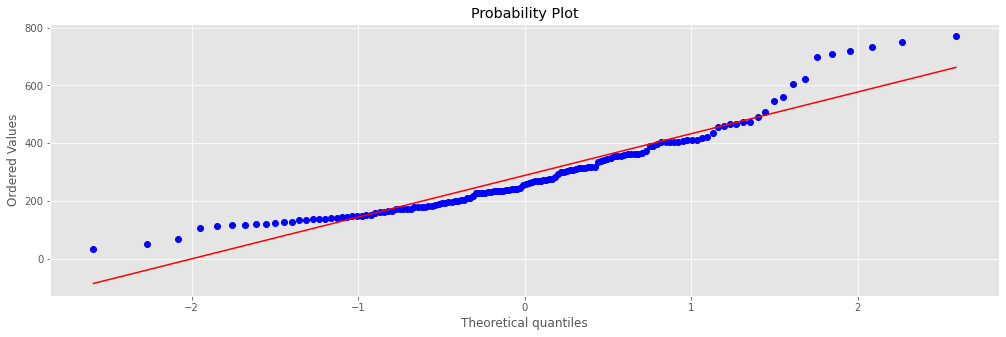

In [14]:
import scipy.stats
import pylab 
scipy.stats.probplot(df['Customers'],plot=pylab)
# pylab.show()

# Y-Axis: Data Value
# X-Axis: 

# Naive Decomposition
### Additive Seasonal Decomposition

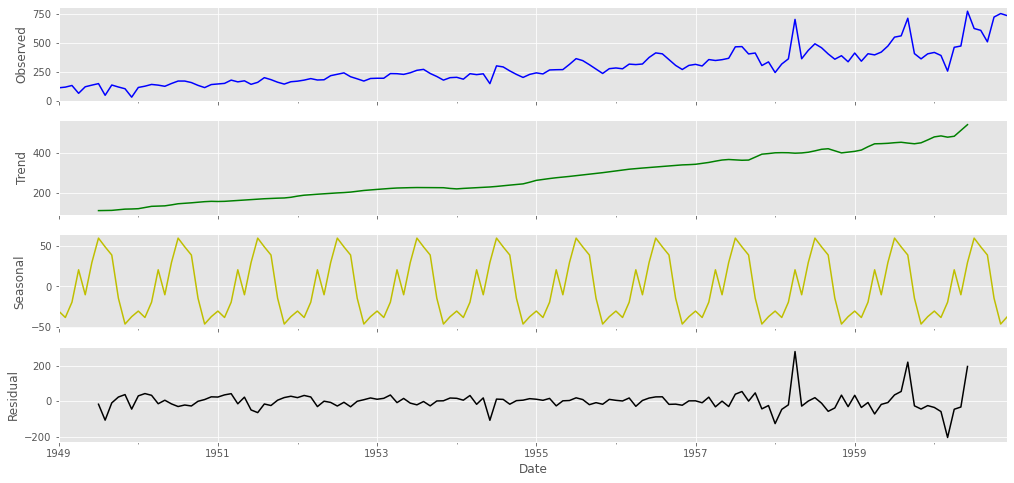

In [15]:
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='additive')
#decomposition.plot()

fig, axes = plt.subplots(4, 1, sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False, color='b')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, color='y')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')                           
plt.show()

### Multiplicative Seasonal Decomposition

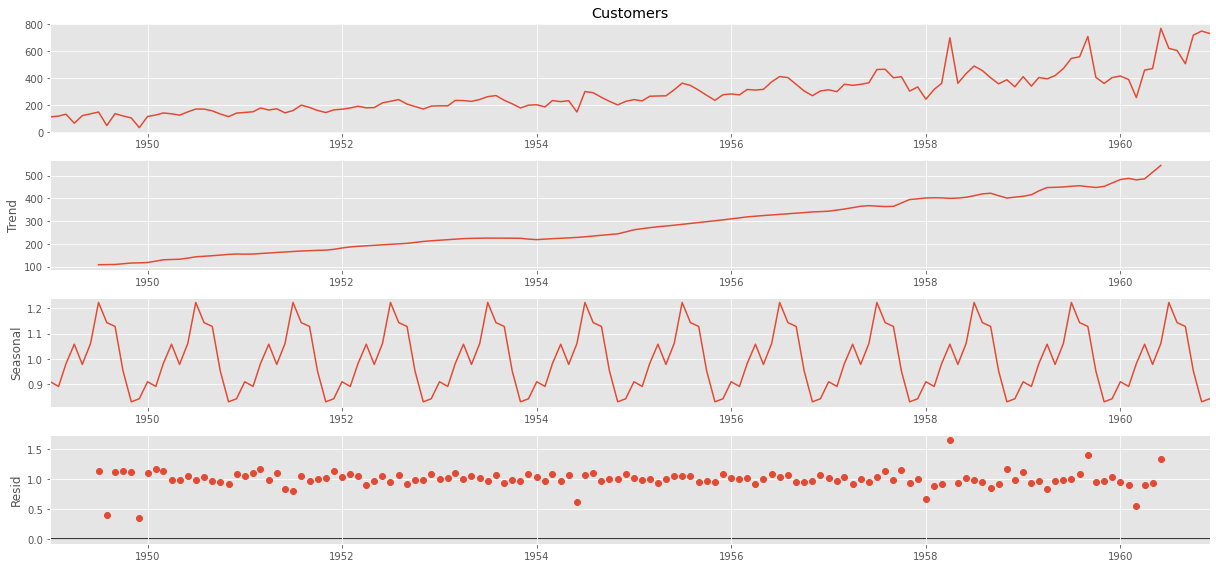

In [16]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Splitting Train and Test data

In [17]:
length = int(np.round(len(df["Customers_linear"])*0.8))
print(length)

115


In [18]:
df.drop(columns=["Customers_mean","Customers_linear"], inplace=True)
df.index.freq = 'MS'

In [19]:
## iF removing of the index is needed.
#df.reset_index(drop=True, inplace=True)
#df

In [20]:
train = df.iloc[:length,:]
train

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1958-03-01,362.0
1958-04-01,700.0
1958-05-01,363.0


In [21]:
test = df.iloc[length:,: ]
test

,Customers
Date,
1958-08-01,457.000000
1958-09-01,404.000000
1958-10-01,359.000000
1958-11-01,389.000000
1958-12-01,337.000000
1959-01-01,412.000000
1959-02-01,342.000000
1959-03-01,406.000000
1959-04-01,396.000000


In [22]:
print(test.shape)
print(train.shape)

(29, 1)
(115, 1)


In [23]:
SC = StandardScaler()
train = SC.fit_transform(train)
test = SC.transform(test)
train

array([[-1.21245702],
       [-1.15425422],
       [-1.0184477 ],
       [-1.66837891],
       [-1.12515282],
       [-0.9893463 ],
       [-0.86324024],
       [-1.83328683],
       [-0.97964583],
       [-1.14455375],
       [-1.29006074],
       [-1.98849429],
       [-1.18335562],
       [-1.07665049],
       [-0.9311435 ],
       [-0.9893463 ],
       [-1.08635096],
       [-0.85353978],
       [-0.64982999],
       [-0.64982999],
       [-0.77593605],
       [-1.00874723],
       [-1.19305608],
       [-0.94084397],
       [-0.89234164],
       [-0.84383931],
       [-0.57222627],
       [-0.71773325],
       [-0.63042906],
       [-0.92144304],
       [-0.75653512],
       [-0.36851648],
       [-0.5334244 ],
       [-0.74683465],
       [-0.90204211],
       [-0.70803279],
       [-0.65953046],
       [-0.57222627],
       [-0.44612021],
       [-0.5625258 ],
       [-0.54312487],
       [-0.20360856],
       [-0.08720297],
       [ 0.02920262],
       [-0.29091276],
       [-0

## RNN with Convolution

### Change Data to RNN Architecture

In [24]:
stepsize = 18 #Should be optimized!

def RNN_Structure(df, stepsize):
    X =[]
    Y =[]
    
    for n in range(len(df) - stepsize):
        z = n + stepsize
        X.append(df[n:z,]) #sample =10
        Y.append(df[z,])   #sample = 11 is your label
        
    return np.array(X) , np.array(Y)

        
X_train ,Y_train =  RNN_Structure(train, stepsize)
X_test  , Y_test =  RNN_Structure(test, stepsize)

In [25]:
print(X_train.shape) # X_train value with step = 10
print(X_test.shape)  # X_Test value with step = 10
print(Y_train.shape) # X_train value with step = 10
print(Y_test.shape)  # X_Test value with step = 10

(97, 18, 1)
(11, 18, 1)
(97, 1)
(11, 1)


* First Argument: Sample size
* Second Argument: Time Step
* Third Argument: Number of Feature

**(Sample size, Step Lenght/Sequence Lenght, Number of Input Feature/ Input Value to RNN)**

In [26]:
## Not necessary for this series, since already done in the previous definition function. But in case:

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_train.shape)
# print(X_test.shape)

In [27]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

### Simple RNN

## RNN parameter tunning with Randomized Search

In [29]:
from keras.wrappers.scikit_learn import KerasRegressor
parameters = {"batch_size": [10,20,50], 
             "optimizer": ["RMSprop", "adam", "nadam", "SGD"],
             "activation": ["tanh","relu","LeakyReLU","selu","elu"]}
def build_model(batch_size, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units=512, return_sequences=True, activation = activation))
    model.add(SimpleRNN(units=512, return_sequences=False, activation = activation))
    model.add(Dense(1, activation="LeakyReLU"))
    model.compile(loss ="mse", optimizer = optimizer, metrics="logcosh")
    return model
model = KerasRegressor(build_fn = build_model, batch_size = 10, epochs = 150, 
                        validation_data=(X_test,Y_test), verbose=2)

rand_search = RandomizedSearchCV(estimator=model, param_distributions = parameters, n_jobs=-1)

#memory = model.fit(X_train, Y_train , epochs = 150, batch_size = 100, use_multiprocessing=True)

In [30]:
from sklearn.metrics import mean_squared_error
rand_search.fit(X_train, Y_train)
best_parameters = rand_search.best_params_
best_accuracy = rand_search.best_score_
results = rand_search.cv_results_
print(best_parameters, best_accuracy, results, sep="\n")

Epoch 1/150
5/5 - 1s - loss: 0.7942 - logcosh: 0.2816 - val_loss: 6.8183 - val_logcosh: 1.6820
Epoch 2/150
5/5 - 0s - loss: 0.5165 - logcosh: 0.1910 - val_loss: 3.1365 - val_logcosh: 0.9412
Epoch 3/150
5/5 - 0s - loss: 0.4102 - logcosh: 0.1579 - val_loss: 2.1490 - val_logcosh: 0.6919
Epoch 4/150
5/5 - 0s - loss: 0.3954 - logcosh: 0.1548 - val_loss: 1.6693 - val_logcosh: 0.5447
Epoch 5/150
5/5 - 0s - loss: 0.3930 - logcosh: 0.1589 - val_loss: 2.9816 - val_logcosh: 0.9039
Epoch 6/150
5/5 - 0s - loss: 0.3817 - logcosh: 0.1492 - val_loss: 2.2205 - val_logcosh: 0.7104
Epoch 7/150
5/5 - 0s - loss: 0.3559 - logcosh: 0.1420 - val_loss: 1.9918 - val_logcosh: 0.6488
Epoch 8/150
5/5 - 0s - loss: 0.3438 - logcosh: 0.1358 - val_loss: 1.8645 - val_logcosh: 0.6128
Epoch 9/150
5/5 - 0s - loss: 0.3543 - logcosh: 0.1455 - val_loss: 3.7239 - val_logcosh: 1.0769
Epoch 10/150
5/5 - 0s - loss: 0.3572 - logcosh: 0.1402 - val_loss: 1.7954 - val_logcosh: 0.5927
Epoch 11/150
5/5 - 0s - loss: 0.3122 - logcosh: 0

Epoch 87/150
5/5 - 0s - loss: 0.0743 - logcosh: 0.0358 - val_loss: 2.7512 - val_logcosh: 0.8554
Epoch 88/150
5/5 - 0s - loss: 0.0722 - logcosh: 0.0347 - val_loss: 2.2205 - val_logcosh: 0.6994
Epoch 89/150
5/5 - 0s - loss: 0.0718 - logcosh: 0.0347 - val_loss: 2.4958 - val_logcosh: 0.7876
Epoch 90/150
5/5 - 0s - loss: 0.0720 - logcosh: 0.0344 - val_loss: 2.3174 - val_logcosh: 0.7461
Epoch 91/150
5/5 - 0s - loss: 0.0744 - logcosh: 0.0356 - val_loss: 2.2677 - val_logcosh: 0.7256
Epoch 92/150
5/5 - 0s - loss: 0.0797 - logcosh: 0.0381 - val_loss: 2.1504 - val_logcosh: 0.6811
Epoch 93/150
5/5 - 0s - loss: 0.0895 - logcosh: 0.0420 - val_loss: 2.5454 - val_logcosh: 0.8063
Epoch 94/150
5/5 - 0s - loss: 0.0649 - logcosh: 0.0313 - val_loss: 2.1758 - val_logcosh: 0.6893
Epoch 95/150
5/5 - 0s - loss: 0.0693 - logcosh: 0.0333 - val_loss: 2.7121 - val_logcosh: 0.8530
Epoch 96/150
5/5 - 0s - loss: 0.0837 - logcosh: 0.0401 - val_loss: 4.5574 - val_logcosh: 1.2532
Epoch 97/150
5/5 - 0s - loss: 0.0844 - l

## RNN model with the best Randomized Search Parameters

In [32]:
RNN = Sequential()
RNN.add(SimpleRNN(units=512, return_sequences=True, activation = "relu"))
RNN.add(SimpleRNN(units=512, return_sequences=False, activation = "relu"))
RNN.add(Dense(1, activation="LeakyReLU"))
RNN.compile(loss ="mse", optimizer = "SGD", metrics="logcosh")

In [39]:
memory = RNN.fit(X_train, Y_train, epochs = 500, batch_size = 20, use_multiprocessing=True) 

Epoch 1/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0093 - logcosh: 0.0045
Epoch 2/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0112 - logcosh: 0.0055
Epoch 3/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0090 - logcosh: 0.0044
Epoch 4/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0089 - logcosh: 0.0044
Epoch 5/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0086 - logcosh: 0.0042
Epoch 6/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0085 - logcosh: 0.0041
Epoch 7/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0095 - logcosh: 0.0047
Epoch 8/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0089 - logcosh: 0.0044
Epoch 9/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0087 - logcosh: 0.0042
Epoch 10/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0106 - logcosh: 0.0052
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 22ms/step - loss: 0.0076 - logcosh: 0.0037
Epoch 85/500
5/5 [==============================] - 0s 24ms/step - loss: 0.0073 - logcosh: 0.0036
Epoch 86/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0075 - logcosh: 0.0037
Epoch 87/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0074 - logcosh: 0.0036
Epoch 88/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0078 - logcosh: 0.0038
Epoch 89/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0074 - logcosh: 0.0036
Epoch 90/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0071 - logcosh: 0.0035
Epoch 91/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0073 - logcosh: 0.0036
Epoch 92/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0070 - logcosh: 0.0035
Epoch 93/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0083 - logcosh: 0.0041
Epoch 94/500
5/5 [===============

5/5 [==============================] - 0s 22ms/step - loss: 0.0066 - logcosh: 0.0033
Epoch 168/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0068 - logcosh: 0.0033
Epoch 169/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0061 - logcosh: 0.0030
Epoch 170/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0063 - logcosh: 0.0031
Epoch 171/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0080 - logcosh: 0.0039
Epoch 172/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0065 - logcosh: 0.0032
Epoch 173/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0062 - logcosh: 0.0031
Epoch 174/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0065 - logcosh: 0.0032
Epoch 175/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0062 - logcosh: 0.0031
Epoch 176/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0069 - logcosh: 0.0034
Epoch 177/500
5/5 [=====

5/5 [==============================] - 0s 21ms/step - loss: 0.0060 - logcosh: 0.0029
Epoch 250/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0053 - logcosh: 0.0026
Epoch 251/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0050 - logcosh: 0.0025
Epoch 252/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0053 - logcosh: 0.0026
Epoch 253/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0055 - logcosh: 0.0027
Epoch 254/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0051 - logcosh: 0.0025
Epoch 255/500
5/5 [==============================] - 0s 24ms/step - loss: 0.0053 - logcosh: 0.0026
Epoch 256/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0051 - logcosh: 0.0025
Epoch 257/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0052 - logcosh: 0.0026
Epoch 258/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0049 - logcosh: 0.0024
Epoch 259/500
5/5 [=====

5/5 [==============================] - 0s 23ms/step - loss: 0.0043 - logcosh: 0.0021
Epoch 332/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0042 - logcosh: 0.0021
Epoch 333/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0041 - logcosh: 0.0020
Epoch 334/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0040 - logcosh: 0.0020
Epoch 335/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0041 - logcosh: 0.0020
Epoch 336/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0042 - logcosh: 0.0021
Epoch 337/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0046 - logcosh: 0.0023
Epoch 338/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0046 - logcosh: 0.0023
Epoch 339/500
5/5 [==============================] - 0s 25ms/step - loss: 0.0040 - logcosh: 0.0020
Epoch 340/500
5/5 [==============================] - 0s 25ms/step - loss: 0.0042 - logcosh: 0.0021
Epoch 341/500
5/5 [=====

5/5 [==============================] - 0s 24ms/step - loss: 0.0033 - logcosh: 0.0016
Epoch 414/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0034 - logcosh: 0.0017
Epoch 415/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0047 - logcosh: 0.0023
Epoch 416/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0035 - logcosh: 0.0017
Epoch 417/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0035 - logcosh: 0.0017
Epoch 418/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0032 - logcosh: 0.0016
Epoch 419/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0035 - logcosh: 0.0018
Epoch 420/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0036 - logcosh: 0.0018
Epoch 421/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0033 - logcosh: 0.0016
Epoch 422/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0040 - logcosh: 0.0020
Epoch 423/500
5/5 [=====

5/5 [==============================] - 0s 22ms/step - loss: 0.0025 - logcosh: 0.0013  
Epoch 496/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0030 - logcosh: 0.0015
Epoch 497/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0039 - logcosh: 0.0019
Epoch 498/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0030 - logcosh: 0.0015  
Epoch 499/500
5/5 [==============================] - 0s 24ms/step - loss: 0.0030 - logcosh: 0.0015
Epoch 500/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0027 - logcosh: 0.0014  


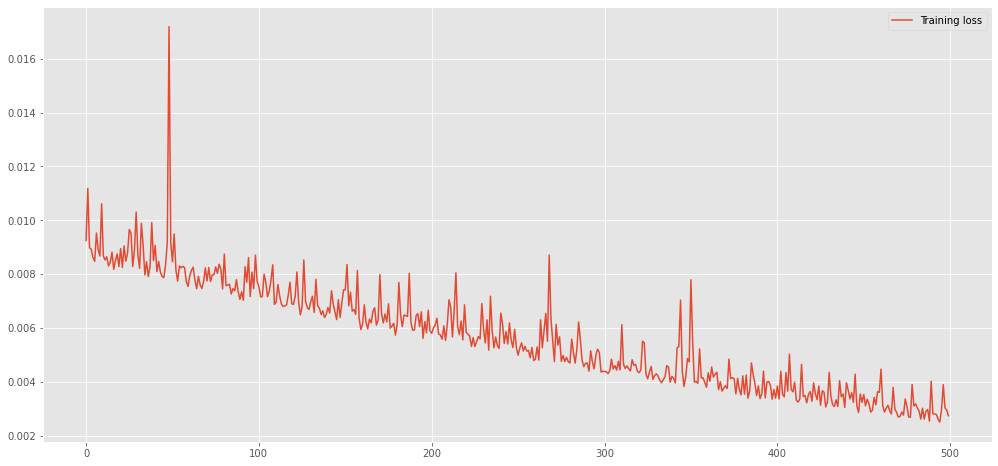

In [40]:
Loss_func = memory.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [42]:
RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 18, 512)           263168    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 788,481
Trainable params: 788,481
Non-trainable params: 0
_________________________________________________________________


In [44]:
score = RNN.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh

[0.0032816710881888866, 0.001634593470953405]

In [45]:
#X_train = np.reshape(X_train, (-1,1))
#X_test = np.reshape(X_test, (-1,1))
print(X_train.shape)
print(X_test.shape)

(97, 18, 1)
(11, 18, 1)


In [47]:
pred_train = SC.inverse_transform(RNN.predict(X_train))
pred_test = SC.inverse_transform(RNN.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [48]:
pred

,0
0,171.141251
1,178.414932
2,163.659912
3,135.644608
4,123.056137
...,...
103,679.624023
104,674.884766
105,393.189087
106,602.673950


In [49]:
df.reset_index(inplace=True, drop=True)
df

,Customers
0,114.0
1,120.0
2,134.0
3,67.0
4,123.0
...,...
139,606.0
140,508.0
141,720.0
142,750.0


<function matplotlib.pyplot.show(close=None, block=None)>

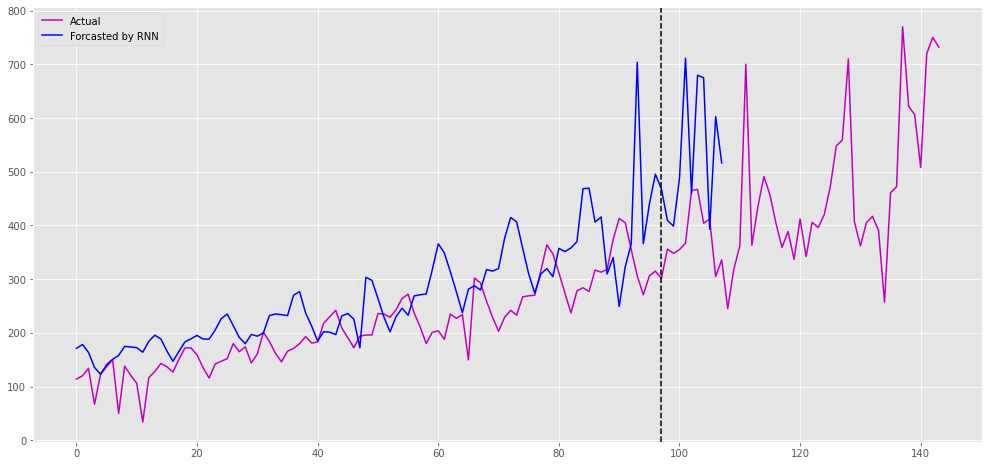

In [50]:
plt.plot(df, color="m")
plt.plot(pred, color="blue")
plt.legend(["Actual","Forcasted by RNN"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### Long-Short Term Memory (LSTM)

## LSTM parameter tunning with Randomized Search

In [51]:
from keras.wrappers.scikit_learn import KerasRegressor
parameters = {"batch_size": [10,20,50], 
             "optimizer": ["RMSprop", "adam", "nadam", "SGD"],
             "activation": ["tanh","relu","LeakyReLU","selu","elu"]}
def build_model1(batch_size, optimizer, activation):
    model1 = Sequential()
    model1.add(LSTM(units=512, return_sequences=True, activation = activation))
    model1.add(LSTM(units=512, return_sequences=False, activation = activation))
    model1.add(Dense(1, activation="LeakyReLU"))
    model1.compile(loss ="mse", optimizer = optimizer, metrics="logcosh")
    return model1
model1 = KerasRegressor(build_fn = build_model1, batch_size = 10, epochs = 150, 
                        validation_data=(X_test,Y_test), verbose=2)

rand_search = RandomizedSearchCV(estimator=model1, param_distributions = parameters, n_jobs=-1)

#memory = model.fit(X_train, Y_train , epochs = 150, batch_size = 100, use_multiprocessing=True)

In [52]:
from sklearn.metrics import mean_squared_error
rand_search.fit(X_train, Y_train)
best_parameters = rand_search.best_params_
best_accuracy = rand_search.best_score_
results = rand_search.cv_results_
print("Best parameters are:", best_parameters, "Best performance is for:", 
      best_accuracy, "The results are as follows:", results, sep="\n")

Epoch 1/150
2/2 - 2s - loss: 2.6511 - logcosh: 0.6742 - val_loss: 14.8759 - val_logcosh: 2.8682
Epoch 2/150
2/2 - 0s - loss: 0.8570 - logcosh: 0.2939 - val_loss: 3.5614 - val_logcosh: 1.0468
Epoch 3/150
2/2 - 0s - loss: 0.2908 - logcosh: 0.1142 - val_loss: 3.4567 - val_logcosh: 1.0217
Epoch 4/150
2/2 - 0s - loss: 0.3019 - logcosh: 0.1136 - val_loss: 2.8776 - val_logcosh: 0.8969
Epoch 5/150
2/2 - 0s - loss: 0.3319 - logcosh: 0.1242 - val_loss: 2.8725 - val_logcosh: 0.8931
Epoch 6/150
2/2 - 0s - loss: 0.2670 - logcosh: 0.1078 - val_loss: 4.4530 - val_logcosh: 1.2143
Epoch 7/150
2/2 - 0s - loss: 0.2501 - logcosh: 0.0942 - val_loss: 3.0188 - val_logcosh: 0.9165
Epoch 8/150
2/2 - 0s - loss: 0.3047 - logcosh: 0.1269 - val_loss: 5.0233 - val_logcosh: 1.3152
Epoch 9/150
2/2 - 0s - loss: 0.3368 - logcosh: 0.1268 - val_loss: 5.8292 - val_logcosh: 1.4665
Epoch 10/150
2/2 - 0s - loss: 0.2622 - logcosh: 0.0992 - val_loss: 3.4039 - val_logcosh: 0.9775
Epoch 11/150
2/2 - 0s - loss: 0.2110 - logcosh: 

Epoch 87/150
2/2 - 0s - loss: 0.1534 - logcosh: 0.0608 - val_loss: 4.6120 - val_logcosh: 1.2256
Epoch 88/150
2/2 - 0s - loss: 0.1433 - logcosh: 0.0589 - val_loss: 3.6598 - val_logcosh: 1.0957
Epoch 89/150
2/2 - 0s - loss: 0.1216 - logcosh: 0.0527 - val_loss: 6.7028 - val_logcosh: 1.5372
Epoch 90/150
2/2 - 0s - loss: 0.1411 - logcosh: 0.0559 - val_loss: 3.8347 - val_logcosh: 1.1541
Epoch 91/150
2/2 - 0s - loss: 0.1016 - logcosh: 0.0456 - val_loss: 5.5560 - val_logcosh: 1.4612
Epoch 92/150
2/2 - 0s - loss: 0.1024 - logcosh: 0.0449 - val_loss: 5.3517 - val_logcosh: 1.4812
Epoch 93/150
2/2 - 0s - loss: 0.1114 - logcosh: 0.0515 - val_loss: 6.1470 - val_logcosh: 1.4346
Epoch 94/150
2/2 - 0s - loss: 0.1667 - logcosh: 0.0618 - val_loss: 4.4676 - val_logcosh: 1.2449
Epoch 95/150
2/2 - 0s - loss: 0.1120 - logcosh: 0.0493 - val_loss: 5.0289 - val_logcosh: 1.4415
Epoch 96/150
2/2 - 0s - loss: 0.0927 - logcosh: 0.0430 - val_loss: 7.6455 - val_logcosh: 1.7295
Epoch 97/150
2/2 - 0s - loss: 0.1823 - l

## LSTM model with the best Randomized Search Parameters <font color='red'> (wrong!) </font>

### <font color='red'> The high number of epochs in the following LSTM model resulted in gradient exploding!! (epoch 481 to 500) </font>

In [56]:
lstm = Sequential()
lstm.add(LSTM(units=512, return_sequences=True, activation ="selu"))
lstm.add(LSTM(units=512, return_sequences=False, activation ="selu"))
lstm.add(Dense(1, activation="LeakyReLU"))
lstm.compile(loss ="mse", optimizer='nadam', metrics="logcosh")
memory_lstm = lstm.fit(X_train, Y_train , epochs = 500, batch_size = 50, verbose = 1)

Epoch 1/500
2/2 [==============================] - 2s 167ms/step - loss: 3.9949 - logcosh: 0.8606
Epoch 2/500
2/2 [==============================] - 0s 162ms/step - loss: 0.9261 - logcosh: 0.3102
Epoch 3/500
2/2 [==============================] - 0s 165ms/step - loss: 0.4382 - logcosh: 0.1670
Epoch 4/500
2/2 [==============================] - 0s 165ms/step - loss: 0.3096 - logcosh: 0.1182
Epoch 5/500
2/2 [==============================] - 0s 164ms/step - loss: 0.2919 - logcosh: 0.1077
Epoch 6/500
2/2 [==============================] - 0s 166ms/step - loss: 0.2605 - logcosh: 0.0992
Epoch 7/500
2/2 [==============================] - 0s 164ms/step - loss: 0.2906 - logcosh: 0.1120
Epoch 8/500
2/2 [==============================] - 0s 166ms/step - loss: 0.2661 - logcosh: 0.1020
Epoch 9/500
2/2 [==============================] - 0s 163ms/step - loss: 0.2200 - logcosh: 0.0895
Epoch 10/500
2/2 [==============================] - 0s 160ms/step - loss: 0.2036 - logcosh: 0.0802
Epoch 11/500
2/2 [=

2/2 [==============================] - 0s 161ms/step - loss: 0.1583 - logcosh: 0.0586
Epoch 84/500
2/2 [==============================] - 0s 163ms/step - loss: 0.1676 - logcosh: 0.0623
Epoch 85/500
2/2 [==============================] - 0s 163ms/step - loss: 0.1595 - logcosh: 0.0583
Epoch 86/500
2/2 [==============================] - 0s 188ms/step - loss: 0.1656 - logcosh: 0.0618
Epoch 87/500
2/2 [==============================] - 0s 167ms/step - loss: 0.1372 - logcosh: 0.0551
Epoch 88/500
2/2 [==============================] - 0s 166ms/step - loss: 0.1689 - logcosh: 0.0639
Epoch 89/500
2/2 [==============================] - 0s 159ms/step - loss: 0.1700 - logcosh: 0.0629
Epoch 90/500
2/2 [==============================] - 0s 160ms/step - loss: 0.1522 - logcosh: 0.0586
Epoch 91/500
2/2 [==============================] - 0s 161ms/step - loss: 0.1644 - logcosh: 0.0596
Epoch 92/500
2/2 [==============================] - 0s 162ms/step - loss: 0.1362 - logcosh: 0.0523
Epoch 93/500
2/2 [=====

2/2 [==============================] - 0s 160ms/step - loss: 0.0492 - logcosh: 0.0240
Epoch 166/500
2/2 [==============================] - 0s 164ms/step - loss: 0.0351 - logcosh: 0.0168
Epoch 167/500
2/2 [==============================] - 0s 158ms/step - loss: 0.0544 - logcosh: 0.0258
Epoch 168/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0460 - logcosh: 0.0224
Epoch 169/500
2/2 [==============================] - 0s 166ms/step - loss: 0.0315 - logcosh: 0.0153
Epoch 170/500
2/2 [==============================] - 0s 165ms/step - loss: 0.0333 - logcosh: 0.0161
Epoch 171/500
2/2 [==============================] - 0s 157ms/step - loss: 0.0320 - logcosh: 0.0156
Epoch 172/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0277 - logcosh: 0.0134
Epoch 173/500
2/2 [==============================] - 0s 162ms/step - loss: 0.0336 - logcosh: 0.0163
Epoch 174/500
2/2 [==============================] - 0s 170ms/step - loss: 0.0276 - logcosh: 0.0134
Epoch 175/500


2/2 [==============================] - 0s 166ms/step - loss: 0.0185 - logcosh: 0.0090
Epoch 248/500
2/2 [==============================] - 0s 164ms/step - loss: 0.0442 - logcosh: 0.0205
Epoch 249/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0478 - logcosh: 0.0232
Epoch 250/500
2/2 [==============================] - 0s 157ms/step - loss: 0.0401 - logcosh: 0.0195
Epoch 251/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0245 - logcosh: 0.0118
Epoch 252/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0214 - logcosh: 0.0104
Epoch 253/500
2/2 [==============================] - 0s 164ms/step - loss: 0.0189 - logcosh: 0.0092
Epoch 254/500
2/2 [==============================] - 0s 167ms/step - loss: 0.0210 - logcosh: 0.0103
Epoch 255/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0297 - logcosh: 0.0145
Epoch 256/500
2/2 [==============================] - 0s 175ms/step - loss: 0.0221 - logcosh: 0.0108
Epoch 257/500


2/2 [==============================] - 0s 190ms/step - loss: 0.0091 - logcosh: 0.0045
Epoch 330/500
2/2 [==============================] - 0s 160ms/step - loss: 0.0113 - logcosh: 0.0056
Epoch 331/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0084 - logcosh: 0.0041
Epoch 332/500
2/2 [==============================] - 0s 178ms/step - loss: 0.0074 - logcosh: 0.0037
Epoch 333/500
2/2 [==============================] - 0s 166ms/step - loss: 0.0094 - logcosh: 0.0046
Epoch 334/500
2/2 [==============================] - 0s 191ms/step - loss: 0.0241 - logcosh: 0.0118
Epoch 335/500
2/2 [==============================] - 0s 160ms/step - loss: 0.0285 - logcosh: 0.0140
Epoch 336/500
2/2 [==============================] - 0s 199ms/step - loss: 0.0120 - logcosh: 0.0060
Epoch 337/500
2/2 [==============================] - 0s 180ms/step - loss: 0.0094 - logcosh: 0.0047
Epoch 338/500
2/2 [==============================] - 0s 163ms/step - loss: 0.0167 - logcosh: 0.0082
Epoch 339/500


2/2 [==============================] - 0s 159ms/step - loss: 0.0026 - logcosh: 0.0013
Epoch 412/500
2/2 [==============================] - 0s 159ms/step - loss: 0.0026 - logcosh: 0.0013
Epoch 413/500
2/2 [==============================] - 0s 162ms/step - loss: 0.0026 - logcosh: 0.0013
Epoch 414/500
2/2 [==============================] - 0s 160ms/step - loss: 0.0023 - logcosh: 0.0012
Epoch 415/500
2/2 [==============================] - 0s 158ms/step - loss: 0.0023 - logcosh: 0.0011
Epoch 416/500
2/2 [==============================] - 0s 159ms/step - loss: 0.0016 - logcosh: 8.0359e-04
Epoch 417/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0015 - logcosh: 7.3890e-04
Epoch 418/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0020 - logcosh: 9.8064e-04
Epoch 419/500
2/2 [==============================] - 0s 159ms/step - loss: 0.0024 - logcosh: 0.0012
Epoch 420/500
2/2 [==============================] - 0s 161ms/step - loss: 0.0043 - logcosh: 0.0021
Ep

2/2 [==============================] - 0s 160ms/step - loss: 1200432.2500 - logcosh: 825.5005
Epoch 492/500
2/2 [==============================] - 0s 159ms/step - loss: 5228662.0000 - logcosh: 1256.9834
Epoch 493/500
2/2 [==============================] - 0s 162ms/step - loss: 650438272.0000 - logcosh: 15963.2227
Epoch 494/500
2/2 [==============================] - 0s 159ms/step - loss: 853511.0000 - logcosh: 665.6759
Epoch 495/500
2/2 [==============================] - 0s 163ms/step - loss: 1742263.2500 - logcosh: 981.1742
Epoch 496/500
2/2 [==============================] - 0s 162ms/step - loss: 10025.9023 - logcosh: 80.6768
Epoch 497/500
2/2 [==============================] - 0s 158ms/step - loss: 20612.6504 - logcosh: 107.4198
Epoch 498/500
2/2 [==============================] - 0s 160ms/step - loss: 25554.6797 - logcosh: 123.9722
Epoch 499/500
2/2 [==============================] - 0s 162ms/step - loss: 97920.3750 - logcosh: 267.9680
Epoch 500/500
2/2 [============================

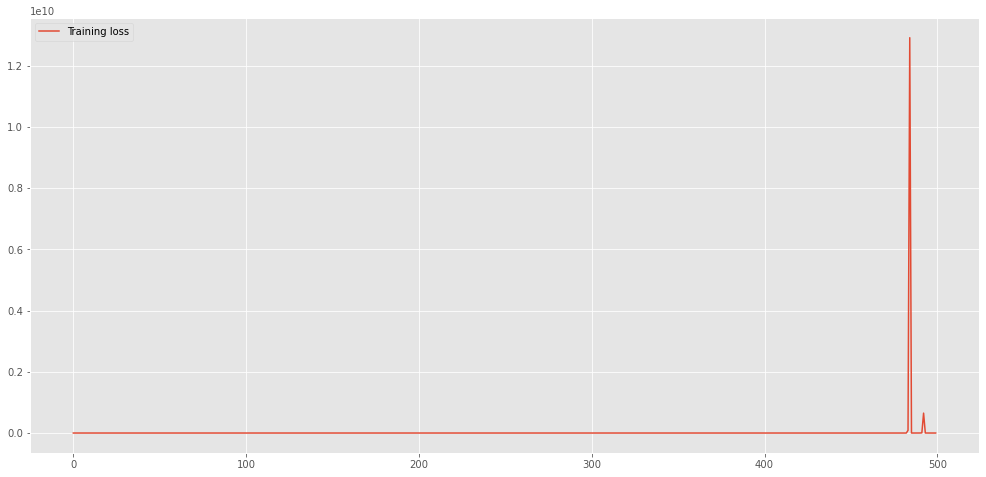

In [59]:
Loss_func = memory_lstm.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

## LSTM model with the best Randomized Search Parameters <font color='green'> (correct!) </font>

In [61]:
lstm = Sequential()
lstm.add(LSTM(units=512, return_sequences=True, activation ="selu"))
lstm.add(LSTM(units=512, return_sequences=False, activation ="selu"))
lstm.add(Dense(1, activation="LeakyReLU"))
lstm.compile(loss ="mse", optimizer='nadam', metrics="logcosh")
memory_lstm = lstm.fit(X_train, Y_train , epochs = 450, batch_size = 50, verbose = 1)

Epoch 1/450
2/2 [==============================] - 2s 162ms/step - loss: 1.3191 - logcosh: 0.4502
Epoch 2/450
2/2 [==============================] - 0s 163ms/step - loss: 1.0389 - logcosh: 0.3395
Epoch 3/450
2/2 [==============================] - 0s 163ms/step - loss: 0.4962 - logcosh: 0.1689
Epoch 4/450
2/2 [==============================] - 0s 163ms/step - loss: 0.2889 - logcosh: 0.1088
Epoch 5/450
2/2 [==============================] - 0s 163ms/step - loss: 0.3693 - logcosh: 0.1355
Epoch 6/450
2/2 [==============================] - 0s 162ms/step - loss: 0.2552 - logcosh: 0.0994
Epoch 7/450
2/2 [==============================] - 0s 159ms/step - loss: 0.2412 - logcosh: 0.0911
Epoch 8/450
2/2 [==============================] - 0s 176ms/step - loss: 0.2706 - logcosh: 0.1118
Epoch 9/450
2/2 [==============================] - 0s 162ms/step - loss: 0.3796 - logcosh: 0.1349
Epoch 10/450
2/2 [==============================] - 0s 163ms/step - loss: 0.2278 - logcosh: 0.0877
Epoch 11/450
2/2 [=

2/2 [==============================] - 0s 161ms/step - loss: 0.1956 - logcosh: 0.0691
Epoch 84/450
2/2 [==============================] - 0s 162ms/step - loss: 0.1481 - logcosh: 0.0613
Epoch 85/450
2/2 [==============================] - 0s 176ms/step - loss: 0.1389 - logcosh: 0.0509
Epoch 86/450
2/2 [==============================] - 0s 165ms/step - loss: 0.1504 - logcosh: 0.0643
Epoch 87/450
2/2 [==============================] - 0s 168ms/step - loss: 0.1288 - logcosh: 0.0482
Epoch 88/450
2/2 [==============================] - 0s 169ms/step - loss: 0.1762 - logcosh: 0.0658
Epoch 89/450
2/2 [==============================] - 0s 167ms/step - loss: 0.2189 - logcosh: 0.0957
Epoch 90/450
2/2 [==============================] - 0s 166ms/step - loss: 0.1645 - logcosh: 0.0600
Epoch 91/450
2/2 [==============================] - 0s 165ms/step - loss: 0.1250 - logcosh: 0.0486
Epoch 92/450
2/2 [==============================] - 0s 165ms/step - loss: 0.1251 - logcosh: 0.0504
Epoch 93/450
2/2 [=====

2/2 [==============================] - 0s 162ms/step - loss: 0.0252 - logcosh: 0.0123
Epoch 166/450
2/2 [==============================] - 0s 160ms/step - loss: 0.0235 - logcosh: 0.0114
Epoch 167/450
2/2 [==============================] - 0s 165ms/step - loss: 0.0211 - logcosh: 0.0103
Epoch 168/450
2/2 [==============================] - 0s 165ms/step - loss: 0.0283 - logcosh: 0.0138
Epoch 169/450
2/2 [==============================] - 0s 168ms/step - loss: 0.0707 - logcosh: 0.0321
Epoch 170/450
2/2 [==============================] - 0s 165ms/step - loss: 0.0520 - logcosh: 0.0253
Epoch 171/450
2/2 [==============================] - 0s 163ms/step - loss: 0.0437 - logcosh: 0.0212
Epoch 172/450
2/2 [==============================] - 0s 162ms/step - loss: 0.0351 - logcosh: 0.0169
Epoch 173/450
2/2 [==============================] - 0s 164ms/step - loss: 0.0275 - logcosh: 0.0134
Epoch 174/450
2/2 [==============================] - 0s 164ms/step - loss: 0.0347 - logcosh: 0.0167
Epoch 175/450


2/2 [==============================] - 0s 162ms/step - loss: 0.0135 - logcosh: 0.0066
Epoch 248/450
2/2 [==============================] - 0s 174ms/step - loss: 0.0121 - logcosh: 0.0060
Epoch 249/450
2/2 [==============================] - 0s 162ms/step - loss: 0.0112 - logcosh: 0.0056
Epoch 250/450
2/2 [==============================] - 0s 160ms/step - loss: 0.0127 - logcosh: 0.0063
Epoch 251/450
2/2 [==============================] - 0s 184ms/step - loss: 0.0177 - logcosh: 0.0087
Epoch 252/450
2/2 [==============================] - 0s 169ms/step - loss: 0.0139 - logcosh: 0.0069
Epoch 253/450
2/2 [==============================] - 0s 176ms/step - loss: 0.0120 - logcosh: 0.0059
Epoch 254/450
2/2 [==============================] - 0s 178ms/step - loss: 0.0169 - logcosh: 0.0083
Epoch 255/450
2/2 [==============================] - 0s 177ms/step - loss: 0.0140 - logcosh: 0.0069
Epoch 256/450
2/2 [==============================] - 0s 170ms/step - loss: 0.0140 - logcosh: 0.0069
Epoch 257/450


2/2 [==============================] - 0s 162ms/step - loss: 0.0790 - logcosh: 0.0372
Epoch 330/450
2/2 [==============================] - 0s 159ms/step - loss: 0.0637 - logcosh: 0.0307
Epoch 331/450
2/2 [==============================] - 0s 159ms/step - loss: 0.0740 - logcosh: 0.0354
Epoch 332/450
2/2 [==============================] - 0s 159ms/step - loss: 0.1195 - logcosh: 0.0567
Epoch 333/450
2/2 [==============================] - 0s 159ms/step - loss: 0.0825 - logcosh: 0.0392
Epoch 334/450
2/2 [==============================] - 0s 159ms/step - loss: 0.0600 - logcosh: 0.0289
Epoch 335/450
2/2 [==============================] - 0s 163ms/step - loss: 0.0523 - logcosh: 0.0254
Epoch 336/450
2/2 [==============================] - 0s 168ms/step - loss: 0.0503 - logcosh: 0.0244
Epoch 337/450
2/2 [==============================] - 0s 159ms/step - loss: 0.0497 - logcosh: 0.0241
Epoch 338/450
2/2 [==============================] - 0s 160ms/step - loss: 0.0558 - logcosh: 0.0271
Epoch 339/450


2/2 [==============================] - 0s 169ms/step - loss: 0.0150 - logcosh: 0.0074
Epoch 412/450
2/2 [==============================] - 0s 172ms/step - loss: 0.0142 - logcosh: 0.0070
Epoch 413/450
2/2 [==============================] - 0s 164ms/step - loss: 0.0136 - logcosh: 0.0067
Epoch 414/450
2/2 [==============================] - 0s 162ms/step - loss: 0.0131 - logcosh: 0.0065
Epoch 415/450
2/2 [==============================] - 0s 163ms/step - loss: 0.0137 - logcosh: 0.0067
Epoch 416/450
2/2 [==============================] - 0s 164ms/step - loss: 0.0179 - logcosh: 0.0088
Epoch 417/450
2/2 [==============================] - 0s 165ms/step - loss: 0.0220 - logcosh: 0.0109
Epoch 418/450
2/2 [==============================] - 0s 165ms/step - loss: 0.0181 - logcosh: 0.0090
Epoch 419/450
2/2 [==============================] - 0s 164ms/step - loss: 0.0173 - logcosh: 0.0085
Epoch 420/450
2/2 [==============================] - 0s 167ms/step - loss: 0.0143 - logcosh: 0.0071
Epoch 421/450


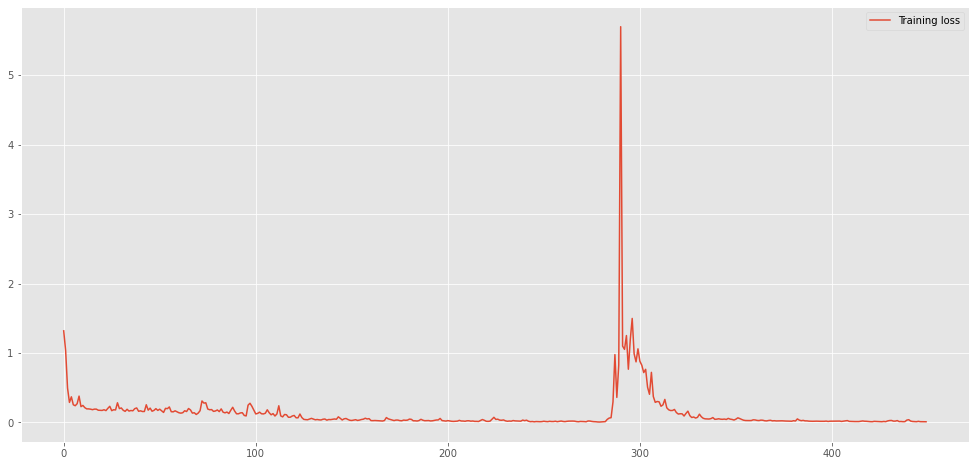

In [62]:
Loss_func = memory_lstm.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [63]:
pred_train = SC.inverse_transform(lstm.predict(X_train))
pred_test = SC.inverse_transform(lstm.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [64]:
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 18, 512)           1052672   
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [65]:
score = lstm.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh                  #Question: Why is the RNN's performance better than LSTM?!

[0.01288068201392889, 0.006364899221807718]

<function matplotlib.pyplot.show(close=None, block=None)>

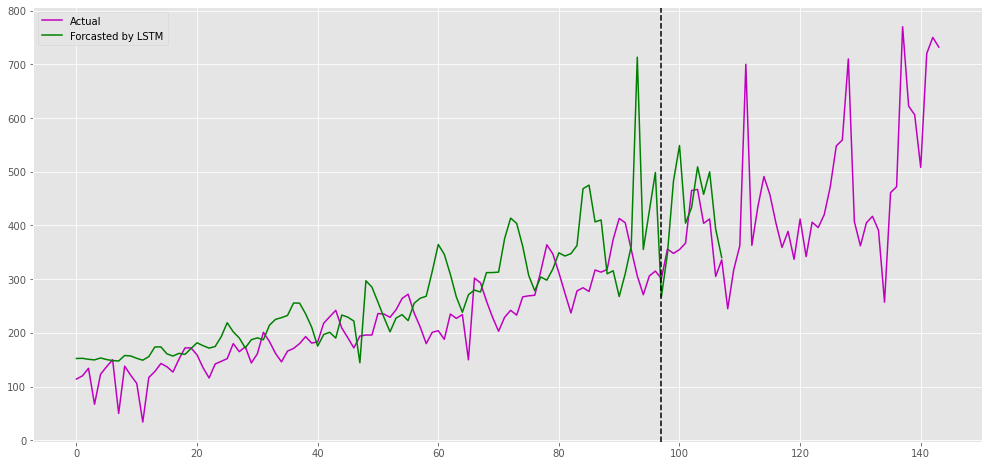

In [66]:
plt.plot(df, color="m")
plt.plot(pred, color="green")
plt.legend(["Actual","Forcasted by LSTM"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show #RNN still works better compared with LSTM even with the attention layer! (Why?)

### Bi-LSTM

## Bi-LSTM parameter tunning with Randomized Search

In [67]:
from keras.wrappers.scikit_learn import KerasRegressor
parameters = {"batch_size": [10,20,50], 
             "optimizer": ["RMSprop", "adam", "nadam", "SGD"],
             "activation": ["tanh","relu","LeakyReLU","selu","elu"]}
def build_model2(batch_size, optimizer, activation):
    model2 = Sequential()
    model2.add(Bidirectional(LSTM(units=512, return_sequences=True, activation = activation)))
    model2.add(Bidirectional(LSTM(units=512, return_sequences=False, activation = activation)))
    model2.add(Dense(1, activation="LeakyReLU"))
    model2.compile(loss ="mse", optimizer = optimizer, metrics="logcosh")
    return model2
model2 = KerasRegressor(build_fn = build_model2, batch_size = 10, epochs = 150, 
                        validation_data=(X_test,Y_test), verbose=2)

rand_search = RandomizedSearchCV(estimator=model2, param_distributions = parameters, n_jobs=-1)

#memory = model.fit(X_train, Y_train , epochs = 150, batch_size = 100, use_multiprocessing=True)

In [68]:
from sklearn.metrics import mean_squared_error
rand_search.fit(X_train, Y_train)
best_parameters = rand_search.best_params_
best_accuracy = rand_search.best_score_
results = rand_search.cv_results_
print("Best parameters are:", best_parameters, "Best performance is for:", 
      best_accuracy, "The results are as follows:", results, sep="\n")

/home/ardavan/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [            nan -3.37836903e-01 -3.08286856e-01 -2.85373013e-01
 -3.77895460e-01 -1.46635763e+04 -3.12147129e-01 -3.58326523e-01
 -1.64272938e+01 -2.20223795e+09]
  warnings.warn(


Epoch 1/150
2/2 - 4s - loss: 0.8252 - logcosh: 0.2858 - val_loss: 5.3715 - val_logcosh: 1.4123
Epoch 2/150
2/2 - 1s - loss: 0.3533 - logcosh: 0.1429 - val_loss: 241.4755 - val_logcosh: 13.4912
Epoch 3/150
2/2 - 1s - loss: 1.5765 - logcosh: 0.4244 - val_loss: 1.8586 - val_logcosh: 0.6246
Epoch 4/150
2/2 - 1s - loss: 0.3157 - logcosh: 0.1193 - val_loss: 5.5637 - val_logcosh: 1.4484
Epoch 5/150
2/2 - 1s - loss: 0.4677 - logcosh: 0.1684 - val_loss: 7.6187 - val_logcosh: 1.8117
Epoch 6/150
2/2 - 1s - loss: 0.5726 - logcosh: 0.2033 - val_loss: 8.5987 - val_logcosh: 1.9715
Epoch 7/150
2/2 - 1s - loss: 0.6163 - logcosh: 0.2172 - val_loss: 8.9913 - val_logcosh: 2.0334
Epoch 8/150
2/2 - 1s - loss: 0.6287 - logcosh: 0.2212 - val_loss: 9.0067 - val_logcosh: 2.0357
Epoch 9/150
2/2 - 1s - loss: 0.6191 - logcosh: 0.2174 - val_loss: 8.6982 - val_logcosh: 1.9871
Epoch 10/150
2/2 - 1s - loss: 0.5888 - logcosh: 0.2070 - val_loss: 8.0630 - val_logcosh: 1.8849
Epoch 11/150
2/2 - 1s - loss: 0.5412 - logcosh

Epoch 87/150
2/2 - 1s - loss: 0.1506 - logcosh: 0.0578 - val_loss: 3.4995 - val_logcosh: 0.8909
Epoch 88/150
2/2 - 1s - loss: 0.1635 - logcosh: 0.0606 - val_loss: 3.6810 - val_logcosh: 0.9135
Epoch 89/150
2/2 - 1s - loss: 0.1501 - logcosh: 0.0557 - val_loss: 5.0997 - val_logcosh: 1.1742
Epoch 90/150
2/2 - 1s - loss: 0.1277 - logcosh: 0.0499 - val_loss: 6.5304 - val_logcosh: 1.3927
Epoch 91/150
2/2 - 1s - loss: 0.1277 - logcosh: 0.0511 - val_loss: 6.9162 - val_logcosh: 1.3849
Epoch 92/150
2/2 - 1s - loss: 0.1291 - logcosh: 0.0531 - val_loss: 6.7530 - val_logcosh: 1.3741
Epoch 93/150
2/2 - 1s - loss: 0.1163 - logcosh: 0.0483 - val_loss: 5.1037 - val_logcosh: 1.1096
Epoch 94/150
2/2 - 1s - loss: 0.1167 - logcosh: 0.0462 - val_loss: 3.5068 - val_logcosh: 0.9153
Epoch 95/150
2/2 - 1s - loss: 0.1179 - logcosh: 0.0444 - val_loss: 2.5444 - val_logcosh: 0.7579
Epoch 96/150
2/2 - 1s - loss: 0.1144 - logcosh: 0.0445 - val_loss: 2.9350 - val_logcosh: 0.8591
Epoch 97/150
2/2 - 1s - loss: 0.1186 - l

## Bi-LSTM model with the best Randomized Search Parameters

In [75]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(units=512, return_sequences=True, activation ="relu")))
bilstm.add(Bidirectional(LSTM(units=512, return_sequences=False, activation ="relu")))
bilstm.add(Dense(1, activation="LeakyReLU"))
bilstm.compile(loss ="mean_absolute_error", optimizer='adam', metrics="logcosh")
memory_bilstm = bilstm.fit(X_train, Y_train , epochs = 300, batch_size = 50, verbose = 1)

Epoch 1/300
2/2 [==============================] - 3s 356ms/step - loss: 0.6644 - logcosh: 0.2875
Epoch 2/300
2/2 [==============================] - 1s 352ms/step - loss: 0.4510 - logcosh: 0.1549
Epoch 3/300
2/2 [==============================] - 1s 354ms/step - loss: 0.5161 - logcosh: 0.1961
Epoch 4/300
2/2 [==============================] - 1s 354ms/step - loss: 0.3630 - logcosh: 0.1143
Epoch 5/300
2/2 [==============================] - 1s 351ms/step - loss: 0.3988 - logcosh: 0.1241
Epoch 6/300
2/2 [==============================] - 1s 356ms/step - loss: 0.4066 - logcosh: 0.1244
Epoch 7/300
2/2 [==============================] - 1s 354ms/step - loss: 0.3978 - logcosh: 0.1194
Epoch 8/300
2/2 [==============================] - 1s 357ms/step - loss: 0.4013 - logcosh: 0.1218
Epoch 9/300
2/2 [==============================] - 1s 356ms/step - loss: 0.4052 - logcosh: 0.1248
Epoch 10/300
2/2 [==============================] - 1s 398ms/step - loss: 0.3783 - logcosh: 0.1134
Epoch 11/300
2/2 [=

2/2 [==============================] - 1s 354ms/step - loss: 0.2012 - logcosh: 0.0517
Epoch 84/300
2/2 [==============================] - 1s 350ms/step - loss: 0.2116 - logcosh: 0.0535
Epoch 85/300
2/2 [==============================] - 1s 353ms/step - loss: 0.1999 - logcosh: 0.0508
Epoch 86/300
2/2 [==============================] - 1s 355ms/step - loss: 0.1949 - logcosh: 0.0509
Epoch 87/300
2/2 [==============================] - 1s 354ms/step - loss: 0.1890 - logcosh: 0.0495
Epoch 88/300
2/2 [==============================] - 1s 353ms/step - loss: 0.1947 - logcosh: 0.0508
Epoch 89/300
2/2 [==============================] - 1s 355ms/step - loss: 0.1870 - logcosh: 0.0501
Epoch 90/300
2/2 [==============================] - 1s 354ms/step - loss: 0.1844 - logcosh: 0.0481
Epoch 91/300
2/2 [==============================] - 1s 352ms/step - loss: 0.1849 - logcosh: 0.0467
Epoch 92/300
2/2 [==============================] - 1s 352ms/step - loss: 0.1860 - logcosh: 0.0485
Epoch 93/300
2/2 [=====

2/2 [==============================] - 1s 352ms/step - loss: 0.1253 - logcosh: 0.0314
Epoch 166/300
2/2 [==============================] - 1s 356ms/step - loss: 0.1216 - logcosh: 0.0287
Epoch 167/300
2/2 [==============================] - 1s 351ms/step - loss: 0.1272 - logcosh: 0.0285
Epoch 168/300
2/2 [==============================] - 1s 355ms/step - loss: 0.1196 - logcosh: 0.0323
Epoch 169/300
2/2 [==============================] - 1s 360ms/step - loss: 0.1337 - logcosh: 0.0341
Epoch 170/300
2/2 [==============================] - 1s 352ms/step - loss: 0.1272 - logcosh: 0.0321
Epoch 171/300
2/2 [==============================] - 1s 357ms/step - loss: 0.1274 - logcosh: 0.0290
Epoch 172/300
2/2 [==============================] - 1s 353ms/step - loss: 0.1232 - logcosh: 0.0326
Epoch 173/300
2/2 [==============================] - 1s 355ms/step - loss: 0.1288 - logcosh: 0.0310
Epoch 174/300
2/2 [==============================] - 1s 351ms/step - loss: 0.1318 - logcosh: 0.0296
Epoch 175/300


2/2 [==============================] - 1s 354ms/step - loss: 0.0814 - logcosh: 0.0117
Epoch 248/300
2/2 [==============================] - 1s 349ms/step - loss: 0.0867 - logcosh: 0.0112
Epoch 249/300
2/2 [==============================] - 1s 350ms/step - loss: 0.1006 - logcosh: 0.0162
Epoch 250/300
2/2 [==============================] - 1s 350ms/step - loss: 0.0999 - logcosh: 0.0119
Epoch 251/300
2/2 [==============================] - 1s 354ms/step - loss: 0.1216 - logcosh: 0.0279
Epoch 252/300
2/2 [==============================] - 1s 348ms/step - loss: 0.1200 - logcosh: 0.0206
Epoch 253/300
2/2 [==============================] - 1s 352ms/step - loss: 0.0931 - logcosh: 0.0173
Epoch 254/300
2/2 [==============================] - 1s 350ms/step - loss: 0.0814 - logcosh: 0.0121
Epoch 255/300
2/2 [==============================] - 1s 350ms/step - loss: 0.0893 - logcosh: 0.0106
Epoch 256/300
2/2 [==============================] - 1s 351ms/step - loss: 0.0854 - logcosh: 0.0099
Epoch 257/300


### <font color='magenta'> Higher (epochs > 500) epochs resulted in strange results that I could not find a explanation! Try it!! </font>

In [76]:
pred_train = SC.inverse_transform(bilstm.predict(X_train))
pred_test = SC.inverse_transform(bilstm.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

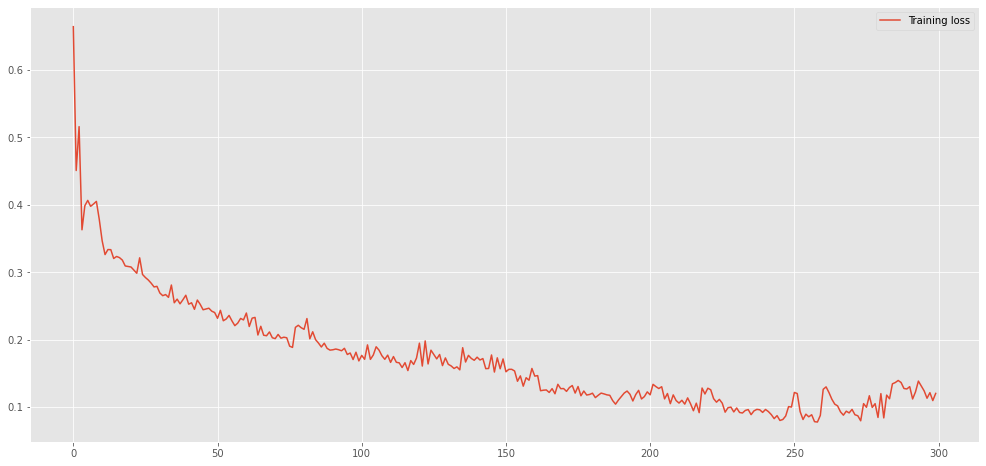

In [77]:
Loss_func = memory_bilstm.history["loss"] 
plt.plot(Loss_func, label= "Training loss")
plt.legend() # People may argue why I have schosen 1000 iterations, but the following diagram is self-descriptive!

In [78]:
bilstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 18, 1024)          2105344   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 8,401,921
Trainable params: 8,401,921
Non-trainable params: 0
_________________________________________________________________


In [79]:
score = bilstm.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh 

[0.10434522479772568, 0.032069526612758636]

<function matplotlib.pyplot.show(close=None, block=None)>

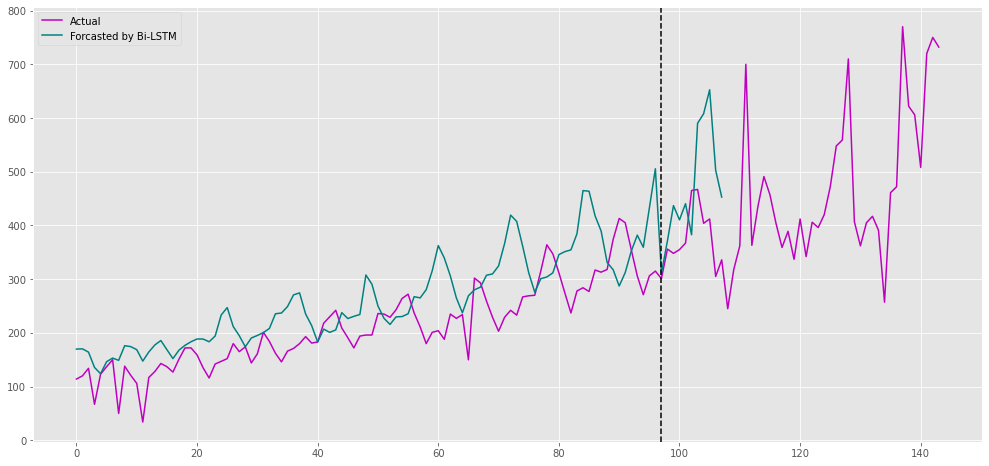

In [80]:
plt.plot(df, color="m")
plt.plot(pred, color="teal")
plt.legend(["Actual","Forcasted by Bi-LSTM"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### Gated Recurrent Unit (GRU)

## GRU parameter tunning with Randomized Search

In [82]:
from keras.wrappers.scikit_learn import KerasRegressor
parameters = {"batch_size": [20,50], 
             "optimizer": ["RMSprop", "adam", "nadam", "SGD"],
             "activation": ["tanh","relu","LeakyReLU","selu","elu"]}
def build_model3(batch_size, optimizer, activation):
    model3 = Sequential()
    model3.add(GRU(units=512, return_sequences=True, activation = activation))
    model3.add(GRU(units=512, return_sequences=False, activation = activation))
    model3.add(Dense(1, activation="LeakyReLU"))
    model3.compile(loss ="mse", optimizer = optimizer, metrics="logcosh")
    return model3
model3 = KerasRegressor(build_fn = build_model3, batch_size = 10, epochs = 150, 
                        validation_data=(X_test,Y_test), verbose=2)

rand_search = RandomizedSearchCV(estimator=model3, param_distributions = parameters, n_jobs=-1)

#memory = model.fit(X_train, Y_train , epochs = 150, batch_size = 100, use_multiprocessing=True)

In [83]:
from sklearn.metrics import mean_squared_error
rand_search.fit(X_train, Y_train)
best_parameters = rand_search.best_params_
best_accuracy = rand_search.best_score_
results = rand_search.cv_results_
print("Best parameters are:", best_parameters, "Best performance is for:", 
      best_accuracy, "The results are as follows:", results, sep="\n")

Epoch 1/150
5/5 - 2s - loss: 0.8494 - logcosh: 0.2966 - val_loss: 6.1613 - val_logcosh: 1.5603
Epoch 2/150
5/5 - 0s - loss: 0.4582 - logcosh: 0.1704 - val_loss: 3.6347 - val_logcosh: 1.0570
Epoch 3/150
5/5 - 0s - loss: 0.3754 - logcosh: 0.1428 - val_loss: 2.8023 - val_logcosh: 0.8638
Epoch 4/150
5/5 - 0s - loss: 0.3516 - logcosh: 0.1341 - val_loss: 2.5519 - val_logcosh: 0.8007
Epoch 5/150
5/5 - 0s - loss: 0.3412 - logcosh: 0.1308 - val_loss: 2.5751 - val_logcosh: 0.8059
Epoch 6/150
5/5 - 0s - loss: 0.3379 - logcosh: 0.1279 - val_loss: 2.2431 - val_logcosh: 0.7182
Epoch 7/150
5/5 - 0s - loss: 0.3349 - logcosh: 0.1276 - val_loss: 2.4256 - val_logcosh: 0.7665
Epoch 8/150
5/5 - 0s - loss: 0.3288 - logcosh: 0.1246 - val_loss: 2.2528 - val_logcosh: 0.7202
Epoch 9/150
5/5 - 0s - loss: 0.3244 - logcosh: 0.1216 - val_loss: 2.0751 - val_logcosh: 0.6703
Epoch 10/150
5/5 - 0s - loss: 0.3226 - logcosh: 0.1222 - val_loss: 2.0900 - val_logcosh: 0.6746
Epoch 11/150
5/5 - 0s - loss: 0.3295 - logcosh: 0

Epoch 87/150
5/5 - 0s - loss: 0.2390 - logcosh: 0.0901 - val_loss: 2.3306 - val_logcosh: 0.7417
Epoch 88/150
5/5 - 0s - loss: 0.2333 - logcosh: 0.0859 - val_loss: 2.2012 - val_logcosh: 0.7104
Epoch 89/150
5/5 - 0s - loss: 0.2415 - logcosh: 0.0907 - val_loss: 2.7011 - val_logcosh: 0.8289
Epoch 90/150
5/5 - 0s - loss: 0.2283 - logcosh: 0.0828 - val_loss: 2.3822 - val_logcosh: 0.7535
Epoch 91/150
5/5 - 0s - loss: 0.2274 - logcosh: 0.0863 - val_loss: 2.9444 - val_logcosh: 0.8843
Epoch 92/150
5/5 - 0s - loss: 0.2292 - logcosh: 0.0853 - val_loss: 3.1605 - val_logcosh: 0.9329
Epoch 93/150
5/5 - 0s - loss: 0.2212 - logcosh: 0.0816 - val_loss: 2.4091 - val_logcosh: 0.7594
Epoch 94/150
5/5 - 0s - loss: 0.2323 - logcosh: 0.0898 - val_loss: 3.5740 - val_logcosh: 1.0236
Epoch 95/150
5/5 - 0s - loss: 0.2577 - logcosh: 0.0942 - val_loss: 3.0230 - val_logcosh: 0.9004
Epoch 96/150
5/5 - 0s - loss: 0.2207 - logcosh: 0.0822 - val_loss: 3.5665 - val_logcosh: 1.0209
Epoch 97/150
5/5 - 0s - loss: 0.2156 - l

## GRU model with the best Randomized Search Parameters

In [84]:
gru = Sequential()
gru.add(GRU(units=512, return_sequences=True, activation ="selu"))
gru.add(GRU(units=512, return_sequences=False, activation ="selu"))
gru.add(Dense(1, activation="LeakyReLU"))
gru.compile(loss ="mse", optimizer='SGD', metrics="logcosh")
memory_gru = gru.fit(X_train, Y_train , epochs = 500, batch_size = 20, verbose = 1)

Epoch 1/500
5/5 [==============================] - 2s 66ms/step - loss: 0.5931 - logcosh: 0.2146
Epoch 2/500
5/5 [==============================] - 0s 66ms/step - loss: 0.4005 - logcosh: 0.1528
Epoch 3/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3698 - logcosh: 0.1407
Epoch 4/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3587 - logcosh: 0.1366
Epoch 5/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3509 - logcosh: 0.1340
Epoch 6/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3513 - logcosh: 0.1336
Epoch 7/500
5/5 [==============================] - 0s 68ms/step - loss: 0.3390 - logcosh: 0.1282
Epoch 8/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3348 - logcosh: 0.1265
Epoch 9/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3328 - logcosh: 0.1244
Epoch 10/500
5/5 [==============================] - 0s 67ms/step - loss: 0.3387 - logcosh: 0.1292
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 69ms/step - loss: 0.2546 - logcosh: 0.0954
Epoch 85/500
5/5 [==============================] - 0s 74ms/step - loss: 0.2392 - logcosh: 0.0880
Epoch 86/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2635 - logcosh: 0.1027
Epoch 87/500
5/5 [==============================] - 0s 67ms/step - loss: 0.2400 - logcosh: 0.0873
Epoch 88/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2367 - logcosh: 0.0913
Epoch 89/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2432 - logcosh: 0.0878
Epoch 90/500
5/5 [==============================] - 0s 67ms/step - loss: 0.2537 - logcosh: 0.0937
Epoch 91/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2323 - logcosh: 0.0848
Epoch 92/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2295 - logcosh: 0.0844
Epoch 93/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2568 - logcosh: 0.0976
Epoch 94/500
5/5 [===============

5/5 [==============================] - 0s 66ms/step - loss: 0.2229 - logcosh: 0.0833
Epoch 168/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2059 - logcosh: 0.0795
Epoch 169/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1965 - logcosh: 0.0739
Epoch 170/500
5/5 [==============================] - 0s 67ms/step - loss: 0.2108 - logcosh: 0.0810
Epoch 171/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2001 - logcosh: 0.0754
Epoch 172/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2095 - logcosh: 0.0789
Epoch 173/500
5/5 [==============================] - 0s 67ms/step - loss: 0.2516 - logcosh: 0.0951
Epoch 174/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2136 - logcosh: 0.0807
Epoch 175/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1994 - logcosh: 0.0748
Epoch 176/500
5/5 [==============================] - 0s 67ms/step - loss: 0.1987 - logcosh: 0.0749
Epoch 177/500
5/5 [=====

5/5 [==============================] - 0s 67ms/step - loss: 0.2033 - logcosh: 0.0766
Epoch 250/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2048 - logcosh: 0.0816
Epoch 251/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2193 - logcosh: 0.0832
Epoch 252/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1837 - logcosh: 0.0723
Epoch 253/500
5/5 [==============================] - 0s 67ms/step - loss: 0.1929 - logcosh: 0.0731
Epoch 254/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1972 - logcosh: 0.0820
Epoch 255/500
5/5 [==============================] - 0s 67ms/step - loss: 0.1960 - logcosh: 0.0756
Epoch 256/500
5/5 [==============================] - 0s 68ms/step - loss: 0.1842 - logcosh: 0.0704
Epoch 257/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2312 - logcosh: 0.0897
Epoch 258/500
5/5 [==============================] - 0s 67ms/step - loss: 0.2017 - logcosh: 0.0746
Epoch 259/500
5/5 [=====

5/5 [==============================] - 0s 65ms/step - loss: 0.1909 - logcosh: 0.0724
Epoch 332/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1985 - logcosh: 0.0759
Epoch 333/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1855 - logcosh: 0.0703
Epoch 334/500
5/5 [==============================] - 0s 67ms/step - loss: 0.2049 - logcosh: 0.0769
Epoch 335/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1902 - logcosh: 0.0724
Epoch 336/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1876 - logcosh: 0.0765
Epoch 337/500
5/5 [==============================] - 0s 67ms/step - loss: 0.1872 - logcosh: 0.0752
Epoch 338/500
5/5 [==============================] - 0s 67ms/step - loss: 0.1947 - logcosh: 0.0750
Epoch 339/500
5/5 [==============================] - 0s 66ms/step - loss: 0.2008 - logcosh: 0.0754
Epoch 340/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1867 - logcosh: 0.0708
Epoch 341/500
5/5 [=====

5/5 [==============================] - 0s 66ms/step - loss: 0.1824 - logcosh: 0.0712
Epoch 414/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1788 - logcosh: 0.0737
Epoch 415/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1875 - logcosh: 0.0725
Epoch 416/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1832 - logcosh: 0.0718
Epoch 417/500
5/5 [==============================] - 0s 64ms/step - loss: 0.1758 - logcosh: 0.0682
Epoch 418/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1916 - logcosh: 0.0720
Epoch 419/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1774 - logcosh: 0.0680
Epoch 420/500
5/5 [==============================] - 0s 65ms/step - loss: 0.2049 - logcosh: 0.0796
Epoch 421/500
5/5 [==============================] - 0s 64ms/step - loss: 0.1868 - logcosh: 0.0719
Epoch 422/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1929 - logcosh: 0.0727
Epoch 423/500
5/5 [=====

5/5 [==============================] - 0s 67ms/step - loss: 0.1741 - logcosh: 0.0660
Epoch 496/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1724 - logcosh: 0.0694
Epoch 497/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1808 - logcosh: 0.0688
Epoch 498/500
5/5 [==============================] - 0s 66ms/step - loss: 0.1749 - logcosh: 0.0676
Epoch 499/500
5/5 [==============================] - 0s 65ms/step - loss: 0.1711 - logcosh: 0.0668
Epoch 500/500
5/5 [==============================] - 0s 64ms/step - loss: 0.1754 - logcosh: 0.0683


In [85]:
pred_train = SC.inverse_transform(gru.predict(X_train))
pred_test = SC.inverse_transform(gru.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

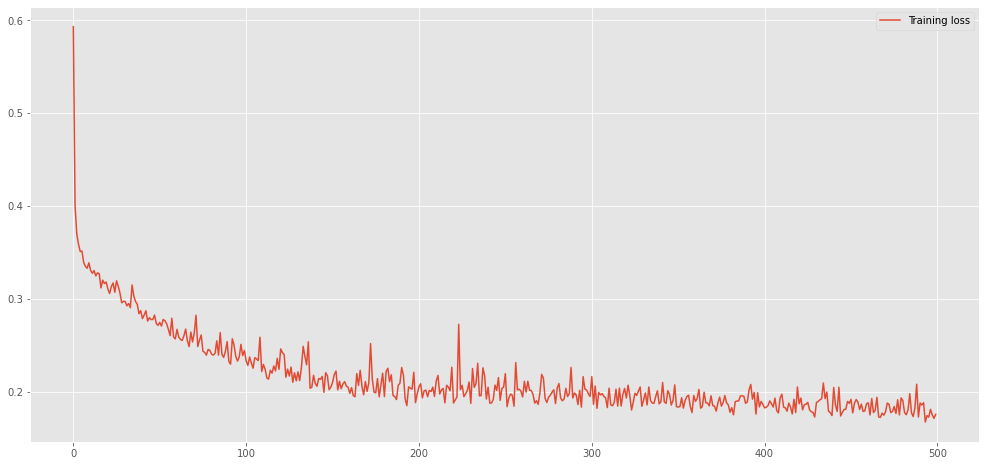

In [86]:
Loss_func = memory_gru.history["loss"] 
plt.plot(Loss_func, label= "Training loss")
plt.legend() 

In [87]:
gru.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 18, 512)           791040    
_________________________________________________________________
gru_3 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 2,367,489
Trainable params: 2,367,489
Non-trainable params: 0
_________________________________________________________________


In [88]:
score = gru.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh 

[0.1677132099866867, 0.06542646884918213]

<function matplotlib.pyplot.show(close=None, block=None)>

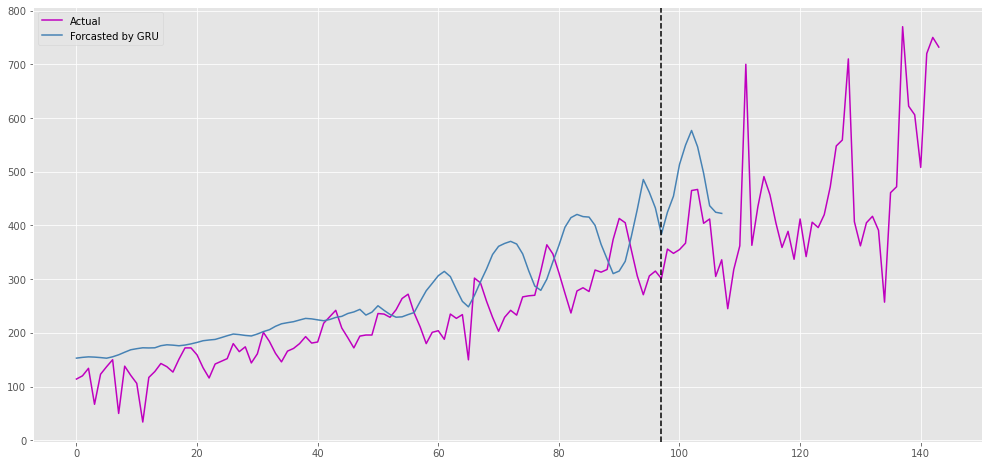

In [89]:
plt.plot(df, color="m")
plt.plot(pred, color="steelblue")
plt.legend(["Actual","Forcasted by GRU"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### <font color='steelblue'> Random search is random anyway and does not gaurentee the best set of parameters. For this dataset, suprisingly simple RNN tends to perform the best (why?). </font>